<a href="https://colab.research.google.com/github/ghiathnj/impacket/blob/master/21_10_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from matplotlib import pyplot
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
######np.random.seed(42)
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sn 
from math import ceil
import calendar
from google.colab import drive
#Connect to the google drive to import the dataset from it
drive.mount('/content/drive')
#import and resample
Energy_df = pd.read_csv('/content/drive/MyDrive/Masterarbeit/data_2019_run12.csv')
Energy_df["time"] = (pd.to_datetime(Energy_df['time']).add(pd.to_timedelta(Energy_df.time, unit='s')).dt.strftime('2019/%m/%d %H:%M:%S'))
Energy_df['time'] = pd.to_datetime(Energy_df['time'])
Energy_resampled = Energy_df.set_index('time').resample('15T').sum()
dftest= Energy_resampled
dftest=dftest.reset_index()
#edit the display
pd.set_option('display.float_format', lambda x: '%.1f' % x)
#drope Unnamed column (unusful)
dftest = dftest.drop(['Unnamed: 0'], axis = 1)

Mounted at /content/drive


In [2]:
#Feature Engineering
##Moving average
dftest['MA12'] = dftest['d_abs'].rolling(window=12).mean() 
dftest['MA20'] = dftest['d_abs'].rolling(window=20).mean() 
dftest['MA26'] = dftest['d_abs'].rolling(window=26).mean() 
dftest['MA100'] = dftest['d_abs'].rolling(window=100).mean()
dftest['MA200'] = dftest['d_abs'].rolling(window=200).mean()
##Moving Averages on std - different periods
dftest['MA20dSTD'] = dftest['d_abs'].rolling(window=20).std() 
## Exponential Moving Averages (EMAS) - different periods
dftest['EMA12'] = dftest['d_abs'].ewm(span=12, adjust=False).mean()
dftest['EMA20'] = dftest['d_abs'].ewm(span=20, adjust=False).mean()
dftest['EMA26'] = dftest['d_abs'].ewm(span=26, adjust=False).mean()
dftest['EMA100'] = dftest['d_abs'].ewm(span=100, adjust=False).mean()
dftest['EMA200'] = dftest['d_abs'].ewm(span=200, adjust=False).mean()
# Bollinger Bands
dftest['Bollinger_Upper'] = dftest['MA20'] + (dftest['MA20dSTD'] * 2)
dftest['Bollinger_Lower'] = dftest['MA20'] - (dftest['MA20dSTD'] * 2)
# Moving Average Convergence/Divergence (MACD)
dftest['MACD'] = dftest['EMA12'] - dftest['EMA26']
##SMA
dftest['DIFF-MA20-MA12'] = dftest['MA20'] - dftest['MA12']
dftest['DIFF-MA200-MA100'] = dftest['MA200'] - dftest['MA100']
dftest['DIFF-MA200-d_abs'] = dftest['MA200'] - dftest['d_abs']
dftest['DIFF-MA100-d_abs'] = dftest['MA100'] - dftest['d_abs']
dftest['DIFF-MA20-d_abs'] = dftest['MA20'] - dftest['d_abs']
##lags features
dftest['t-1'] = dftest['d_abs'].shift(1)
dftest['t-2'] = dftest['d_abs'].shift(2)
dftest['t-3'] = dftest['d_abs'].shift(3)
dftest['t-4'] = dftest['d_abs'].shift(4)
dftest['t-5'] = dftest['d_abs'].shift(5)
# Replace null value caused when adding new features with the max value of the d_abs
nareplace = dftest.at[dftest.index.max(), 'd_abs']    
dftest.fillna((nareplace), inplace=True)
#########dftest=dftest.dropna( axis=0, how="any", thresh=None, subset=None, inplace=False)
#Feature engnineering (old)
def get_season(month):

    if month =='September' or month =='October' or month =='November':
      Season= 'Autumn'
    elif month =='December' or month == 'January' or month =='February':
      Season= 'Winter'
    elif month =='March' or month =='April' or month =='May':
      Season= 'Spring'
    else:
      Season = 'Summer'

    return Season

dftest['Dates'] = pd.to_datetime(dftest['time']).dt.date
#dftest['TimeInHMS'] = pd.to_datetime(dftest['time']).dt.time
dftest['Hour']= pd.to_datetime(dftest['time']).dt.hour
dftest['minute']= pd.to_datetime(dftest['time']).dt.minute
#dftest['second']= pd.to_datetime(dftest['time']).dt.second
dftest['Day'] = pd.to_datetime(dftest['time']).dt.day_name()
dftest['DayOfYear'] = pd.to_datetime(dftest['time']).dt.dayofyear
dftest['Month'] = pd.to_datetime(dftest['time']).dt.month_name()
dftest['MonthInNum'] = pd.to_datetime(dftest['time']).dt.month
dftest['Quarter'] = pd.to_datetime(dftest['time']).dt.quarter
#dftest['Year'] = pd.to_datetime(dftest['time']).dt.year
dftest['Weekday'] = pd.to_datetime(dftest['time']).dt.weekday
dftest['DaysOfMonth'] = pd.to_datetime(dftest['time']).dt.day
#dftest['WeekOfMonth'] = week_of_month(dftest['time'])
#The weekday() function of date class in datetime module, returns an integer between 0(monday) and 6(sunday)
dftest['Seasons'] = dftest['Month'].apply(lambda x: get_season(x))
dftest['Weekend'] = dftest['Weekday'].apply(lambda x: x>=5).astype('int')
dftest['WeekOfYear'] = pd.to_datetime(dftest['time']).dt.week
dftest['Holiday'] = pd.to_datetime(dftest['time']).dt.date.apply(lambda x: holidays.CountryHoliday('DE',prov='BW').get(x)).values.astype('bool').astype('int')
dftest['DayAheadWeekend'] = dftest['Weekday'].apply(lambda x: x==4).astype('int')
dftest['DayAfterWeekend'] = dftest['Weekday'].apply(lambda x: x==0).astype('int')
dftest['Early_Morning'] = dftest['Hour'].apply(lambda x:(x > 4) and (x <= 8) ).astype('int')
dftest['Morning'] = dftest['Hour'].apply(lambda x:(x > 8) and (x <= 12 ) ).astype('int')
dftest['Noon'] = dftest['Hour'].apply(lambda x:(x > 16) and (x <= 20) ).astype('int')
dftest['Night'] = dftest['Hour'].apply(lambda x:(x > 20) and (x <= 24)).astype('int')
dftest['Late Night'] = dftest['Hour'].apply(lambda x:(x <= 4)).astype('int')
dftest.head()




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,time,p_eh,p_target,d_abs,MA12,MA20,MA26,MA100,MA200,MA20dSTD,...,Weekend,WeekOfYear,Holiday,DayAheadWeekend,DayAfterWeekend,Early_Morning,Morning,Noon,Night,Late Night
0,2019-01-01 00:00:00,12680917.7,-30000000.0,42680917.7,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
1,2019-01-01 00:15:00,-2466045.5,-26841704.5,24375659.1,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
2,2019-01-01 00:30:00,-14512871.8,-23682529.7,9169657.9,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
3,2019-01-01 00:45:00,-14046240.6,-16904848.3,2858607.8,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
4,2019-01-01 01:00:00,-14546252.9,-15274927.5,760411.1,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1


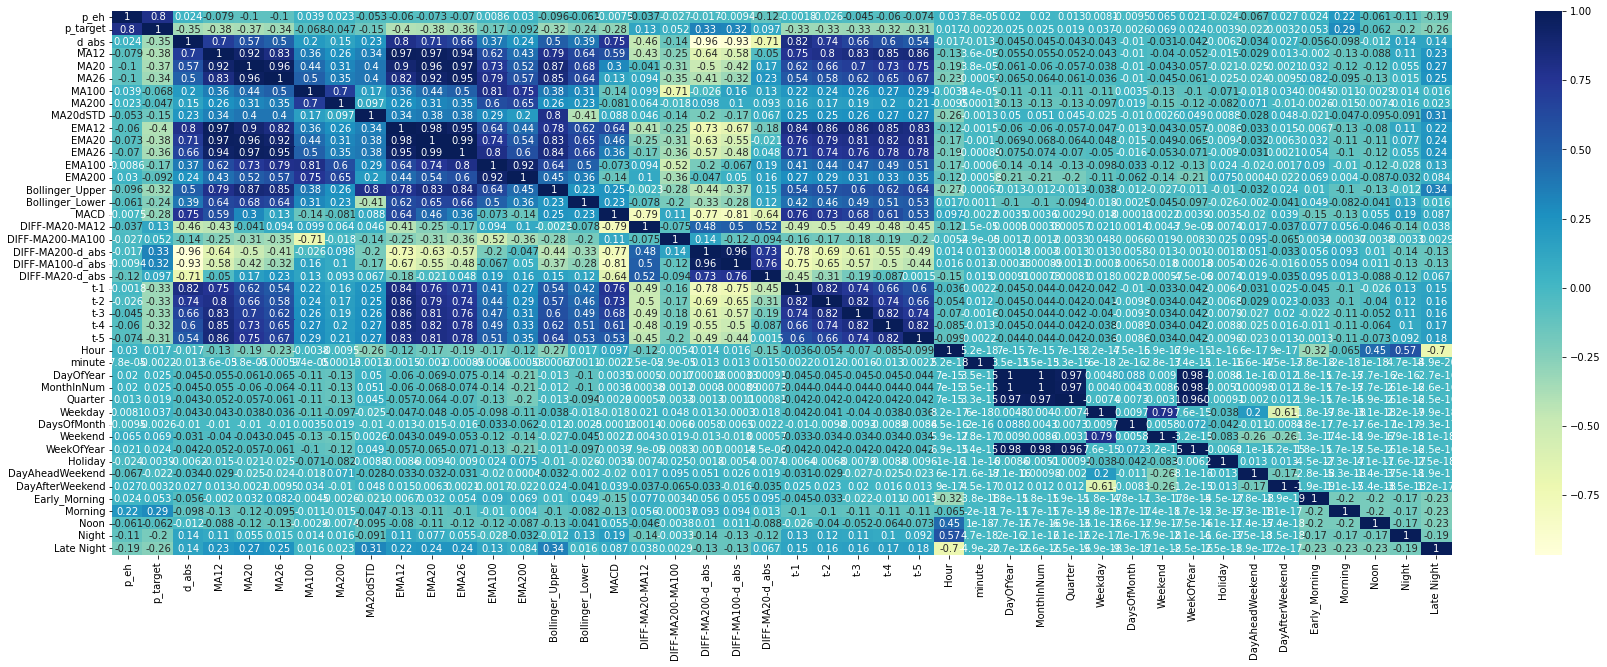

In [3]:
#Correlation matrix to understand the important features for the model
#corr() method of pandas library calculates correlation between columns of dataframe
fig, ax = plt.subplots(1,1,figsize=(30,10))
correlation = dftest.corr() 
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
#plt.figsize=(16,7)
plt.show()

In [4]:
# calculate weekofmonth
from datetime import datetime as dt
from math import ceil
calendar.setfirstweekday(0)

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))
dftest['WeekOfMonth'] = dftest['time'].apply(week_of_month)
#encoding Seasons
from sklearn.preprocessing import LabelEncoder
categorical_features = [ 'Seasons']
le = LabelEncoder()
for i in range(1):
    new = le.fit_transform(dftest[categorical_features[i]])
    dftest[categorical_features[i]] = new
df_train=dftest

#sort by Seasons
Seasons_W  = df_train.query(' Seasons==Seasons.unique()[0]')
Seasons_F  = df_train.query(' Seasons==Seasons.unique()[1]')
Seasons_S = df_train.query(' Seasons==Seasons.unique()[2]')
Seasons_H = df_train.query(' Seasons==Seasons.unique()[3]')
#Apply splitting( training and testing split)
import random
list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
df_for_testing = pd.DataFrame(columns=df_train.columns) 
df_for_training = pd.DataFrame(columns=df_train.columns) 
for i in list_of_datasets:
  test_list=(i.DayOfYear)
  test_list_rand=random.sample(list(test_list),18)# 18 is 20 procent of the three months
  df_for_test_check=i[i.DayOfYear.isin(test_list_rand)]
  df_for_train_check=i[~(i.DayOfYear.isin(test_list_rand))]
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
  proportion_test =round(((df_for_testing.groupby('Weekend').size()/df_for_testing['Weekend'].count())*100).iloc[1])

proportion_test

29

# KNN

In [5]:

#KNN

import time
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training


X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','p_target']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','p_target']]
y_test = df_for_testing['d_abs']
model = KNeighborsRegressor(n_neighbors=2)


start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")




Training time: 0.04127955436706543s


# SVM

In [ ]:
#SVM

import time
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR

scaler = StandardScaler()

df_for_training_apart = df_for_training
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)
X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
model = SVR(kernel='rbf',C=5000, epsilon =0.0000001 )
#model = svm.SVR( C=1000)
#{'C': 1.5, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'poly'}
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")


Training time: 56.42592716217041s


# GradientBoostingRegressor

In [ ]:
#GradientBoostingRegressor

import time
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)
X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
model = GradientBoostingRegressor(random_state=0)
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")


Training time: 17.318485260009766s


# Random Forest

In [ ]:
#Random Forest
import time
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)
X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
model = RandomForestRegressor(n_estimators= 100, max_depth= 50,min_samples_leaf=4,min_samples_split=5)
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")


Training time: 4.689875364303589s


# Neural Networka

In [ ]:
#Neural Network
import time
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)
X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
#1-use parameter alpha for regularization (L2 regularization) term which helps in avoiding overfitting by penalizing weights with large magnitudes.
#2-hidden_layer_sizes= drei hidden layer with each 50 neureus structure
#3-The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
#4-The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
#5-solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’: The solver for weight optimization.‘adam’ refers to a stochastic gradient-based optimizer 
model = MLPRegressor(activation='relu',alpha= 0.05,hidden_layer_sizes= (50, 50, 50),learning_rate= 'constant',solver= 'adam')
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")



Training time: 86.26038789749146s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Metrics


In [6]:
from operator import index
result = pd.DataFrame()
result['y_test'] = y_test
result['y_preds'] = y_preds
result['Absolute error'] = abs(y_test-y_preds)
#####result['Relative_error'] = (result['Absolute error']*100)/result['y_test']
result['MSE']  = (result['y_preds'] - result['y_test'])**2
result['RMSE']= np.sqrt(result['MSE'])
result['MPE'] = ((result['y_test'] - result['y_preds'])/result['y_test'])*100
result['MAPE'] = (np.abs((result['y_test'] - result['y_preds'])/result['y_test'] ))*100
#result['MER'] = (sum(result['Absolute error']/ np.mean(result['y_test'])))*100/len(result)
#mean pro tag
merged=df_for_testing
merged=merged.merge(result[['y_test','y_preds','Absolute error','MSE','RMSE','MPE','MAPE']],how='left',left_index=True,right_index=True)
merged


,time,p_eh,p_target,d_abs,MA12,MA20,MA26,MA100,MA200,MA20dSTD,...,Night,Late Night,WeekOfMonth,y_test,y_preds,Absolute error,MSE,RMSE,MPE,MAPE
288,2019-01-04 00:00:00,-22319922.5,4033635.7,27881001.5,10728429.0,9017002.5,12084524.3,18729403.9,14120309.8,5436732.1,...,0,1,1,27881001.5,14895306.4,12985695.0,168628275829373.2,12985695.0,46.6,46.6
289,2019-01-04 00:15:00,26166063.1,4086090.3,24547584.6,12056092.3,10215471.7,11960153.5,18864601.7,14208075.8,6082165.9,...,0,1,1,24547584.6,9561989.1,14985595.5,224568072791256.2,14985595.5,61.0,61.0
290,2019-01-04 00:30:00,9888386.4,4803030.1,5283988.1,11800229.1,10421648.3,11013281.1,18845384.1,14144900.4,5823447.0,...,0,1,1,5283988.1,18289606.9,13005618.8,169146120438981.5,13005618.8,-246.1,246.1
291,2019-01-04 00:45:00,-3591709.1,3851939.0,7443648.1,11729858.7,10600293.2,9955788.2,18819232.7,14104512.7,5664543.9,...,0,1,1,7443648.1,16709022.2,9265374.1,85847157026128.0,9265374.1,-124.5,124.5
292,2019-01-04 01:00:00,-3608302.5,2923573.1,6531875.6,11698440.9,10650390.9,8867080.6,18219007.9,14046655.3,5621608.9,...,0,1,1,6531875.6,10839130.2,4307254.6,18552442525531.8,4307254.6,-65.9,65.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34075,2019-12-21 22:45:00,-4809465.9,-14357508.4,9548042.4,8103910.2,6242089.8,5994387.3,11521232.0,14638913.0,3781887.6,...,1,0,4,9548042.4,22677747.0,13129704.6,172389143006143.5,13129704.6,-137.5,137.5
34076,2019-12-21 23:00:00,-5492841.0,-13724804.5,8231963.5,8575658.2,6269308.0,6274857.8,11279999.9,14526136.7,3794775.3,...,1,0,4,8231963.5,4767989.5,3463974.1,11999116235539.7,3463974.1,42.1,42.1
34077,2019-12-21 23:15:00,-5509502.6,-18031305.2,12521802.6,9152162.4,6872987.2,6705086.3,11088270.9,14443658.3,3780323.8,...,1,0,4,12521802.6,12204452.7,317349.8,100710925469.2,317349.8,2.5,2.5
34078,2019-12-21 23:30:00,-5642832.2,-15485223.6,9842391.5,9427174.3,6893188.4,6728967.9,10873874.9,14341288.7,3795802.0,...,1,0,4,9842391.5,10774385.0,931993.6,868611983217.6,931993.6,-9.5,9.5


# Mean Error Relative (MER) 


In [7]:
#this worked one for the aggregation
mode_df=merged.groupby(['Dates']).mean()[['y_test']]
merged1=merged.set_index('Dates').merge(mode_df[['y_test']],how='left',left_index=True,right_index=True)
merged1=merged1.rename(columns = {'y_test_y':'Mean_y_test_Daily'})
merged1=merged1.rename(columns = {'y_test_x':'y_test'})
merged1['MER']=(merged1['Absolute error']/merged1['Mean_y_test_Daily'])*100
merged1=merged1.reset_index(None)
merged1

,Dates,time,p_eh,p_target,d_abs,MA12,MA20,MA26,MA100,MA200,...,WeekOfMonth,y_test,y_preds,Absolute error,MSE,RMSE,MPE,MAPE,Mean_y_test_Daily,MER
0,2019-01-04,2019-01-04 00:00:00,-22319922.5,4033635.7,27881001.5,10728429.0,9017002.5,12084524.3,18729403.9,14120309.8,...,1,27881001.5,14895306.4,12985695.0,168628275829373.2,12985695.0,46.6,46.6,9736869.5,133.4
1,2019-01-04,2019-01-04 00:15:00,26166063.1,4086090.3,24547584.6,12056092.3,10215471.7,11960153.5,18864601.7,14208075.8,...,1,24547584.6,9561989.1,14985595.5,224568072791256.2,14985595.5,61.0,61.0,9736869.5,153.9
2,2019-01-04,2019-01-04 00:30:00,9888386.4,4803030.1,5283988.1,11800229.1,10421648.3,11013281.1,18845384.1,14144900.4,...,1,5283988.1,18289606.9,13005618.8,169146120438981.5,13005618.8,-246.1,246.1,9736869.5,133.6
3,2019-01-04,2019-01-04 00:45:00,-3591709.1,3851939.0,7443648.1,11729858.7,10600293.2,9955788.2,18819232.7,14104512.7,...,1,7443648.1,16709022.2,9265374.1,85847157026128.0,9265374.1,-124.5,124.5,9736869.5,95.2
4,2019-01-04,2019-01-04 01:00:00,-3608302.5,2923573.1,6531875.6,11698440.9,10650390.9,8867080.6,18219007.9,14046655.3,...,1,6531875.6,10839130.2,4307254.6,18552442525531.8,4307254.6,-65.9,65.9,9736869.5,44.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,2019-12-21,2019-12-21 22:45:00,-4809465.9,-14357508.4,9548042.4,8103910.2,6242089.8,5994387.3,11521232.0,14638913.0,...,4,9548042.4,22677747.0,13129704.6,172389143006143.5,13129704.6,-137.5,137.5,9774788.2,134.3
5948,2019-12-21,2019-12-21 23:00:00,-5492841.0,-13724804.5,8231963.5,8575658.2,6269308.0,6274857.8,11279999.9,14526136.7,...,4,8231963.5,4767989.5,3463974.1,11999116235539.7,3463974.1,42.1,42.1,9774788.2,35.4
5949,2019-12-21,2019-12-21 23:15:00,-5509502.6,-18031305.2,12521802.6,9152162.4,6872987.2,6705086.3,11088270.9,14443658.3,...,4,12521802.6,12204452.7,317349.8,100710925469.2,317349.8,2.5,2.5,9774788.2,3.2
5950,2019-12-21,2019-12-21 23:30:00,-5642832.2,-15485223.6,9842391.5,9427174.3,6893188.4,6728967.9,10873874.9,14341288.7,...,4,9842391.5,10774385.0,931993.6,868611983217.6,931993.6,-9.5,9.5,9774788.2,9.5


In [8]:
merged1.MER.describe()

count   6432.0
mean      69.9
std       58.7
min        0.0
25%       25.5
50%       55.3
75%       98.3
max      462.8
Name: MER, dtype: float64

#To determine the highst value of an metric

In [89]:
df2=merged1[['time','y_test','y_preds','Dates','Absolute error','MSE','RMSE','MPE','MAPE','MER']]
#df2[0:96].nlargest(10, 'MER')
df2.nlargest(10, 'MER')

,time,y_test,y_preds,Dates,Absolute error,MSE,RMSE,MPE,MAPE,MER
1534,2019-04-27 23:30:00,2039755.3,41679333.3,2019-04-27,39639578.1,1571296149384224.8,39639578.1,-1943.3,1943.3,544.2
1533,2019-04-27 23:15:00,2175614.3,41389808.6,2019-04-27,39214194.3,1537753038239230.0,39214194.3,-1802.4,1802.4,538.4
1535,2019-04-27 23:45:00,2274739.5,41014992.5,2019-04-27,38740253.0,1500807204030721.2,38740253.0,-1703.1,1703.1,531.9
1440,2019-04-27 00:00:00,68959956.9,30357850.2,2019-04-27,38602106.7,1490122641904431.5,38602106.7,56.0,56.0,530.0
1448,2019-04-27 02:00:00,2247293.7,30357850.2,2019-04-27,28110556.5,790203384023182.4,28110556.5,-1250.9,1250.9,385.9
4898,2019-11-13 00:30:00,1784144.7,38965025.0,2019-11-13,37180880.3,1382417861368351.5,37180880.3,-2084.0,2084.0,339.2
2534,2019-06-15 09:30:00,1903854.4,31105789.8,2019-06-15,29201935.4,852753030782065.0,29201935.4,-1533.8,1533.8,338.7
5472,2019-12-07 00:00:00,49692974.8,6003640.8,2019-12-07,43689333.9,1908757898381489.0,43689333.9,87.9,87.9,326.6
4704,2019-11-02 00:00:00,49979422.5,12687339.0,2019-11-02,37292083.5,1390699491935569.2,37292083.5,74.6,74.6,325.6
1155,2019-04-01 00:45:00,1487724.6,37789464.8,2019-04-01,36301740.2,1317816343894388.5,36301740.2,-2440.1,2440.1,325.1


In [22]:
df2[df2['Dates'].values==df2.nlargest(1,'MER').Dates.values]

,time,y_test,y_preds,Dates,Absolute error,MSE,RMSE,MPE,MAPE,MER
2496,2019-05-19 00:00:00,21209631.7,17239870.6,2019-05-19,3969761.1,15759003415703.5,3969761.1,18.7,18.7,56.2
2497,2019-05-19 00:15:00,332390.5,5378409.1,2019-05-19,5046018.6,25462303303481.4,5046018.6,-1518.1,1518.1,71.4
2498,2019-05-19 00:30:00,6505906.0,7098721.4,2019-05-19,592815.4,351430083418.6,592815.4,-9.1,9.1,8.4
2499,2019-05-19 00:45:00,7735578.9,5367675.5,2019-05-19,2367903.4,5606966600317.9,2367903.4,30.6,30.6,33.5
2500,2019-05-19 01:00:00,3412729.6,12627873.9,2019-05-19,9215144.2,84918882811939.3,9215144.2,-270.0,270.0,130.5
...,...,...,...,...,...,...,...,...,...,...
2587,2019-05-19 22:45:00,11351991.3,11875252.5,2019-05-19,523261.3,273802341338.8,523261.3,-4.6,4.6,7.4
2588,2019-05-19 23:00:00,11992596.1,10596282.2,2019-05-19,1396313.8,1949692362009.1,1396313.8,11.6,11.6,19.8
2589,2019-05-19 23:15:00,11798284.5,11411125.8,2019-05-19,387158.6,149891797166.4,387158.6,3.3,3.3,5.5
2590,2019-05-19 23:30:00,11631613.1,12793731.0,2019-05-19,1162117.9,1350518004535.7,1162117.9,-10.0,10.0,16.5


#Note

1. RMSE: it gives more weight to large error since it squares it.
2. MPE: If the sign of MPE is negative, then the model predicts values higher
than actual values. Nevertheless, if the sign is positive, then the model estimate values under than actual values  under-predicts 
3. MAPE as well as MPE are not suitable to use when there are zero values or even very small values in the ground truth since they are calculated by dividing the difference between predicted value and actual
value over the actual value.Therefore, we use Mean Error Relative (MER) as alternative metric.
4. Consequently, the problems that appeared by using MPE
and MAPE are eliminated

#Visualization by the day, where the highst value of the MER observed

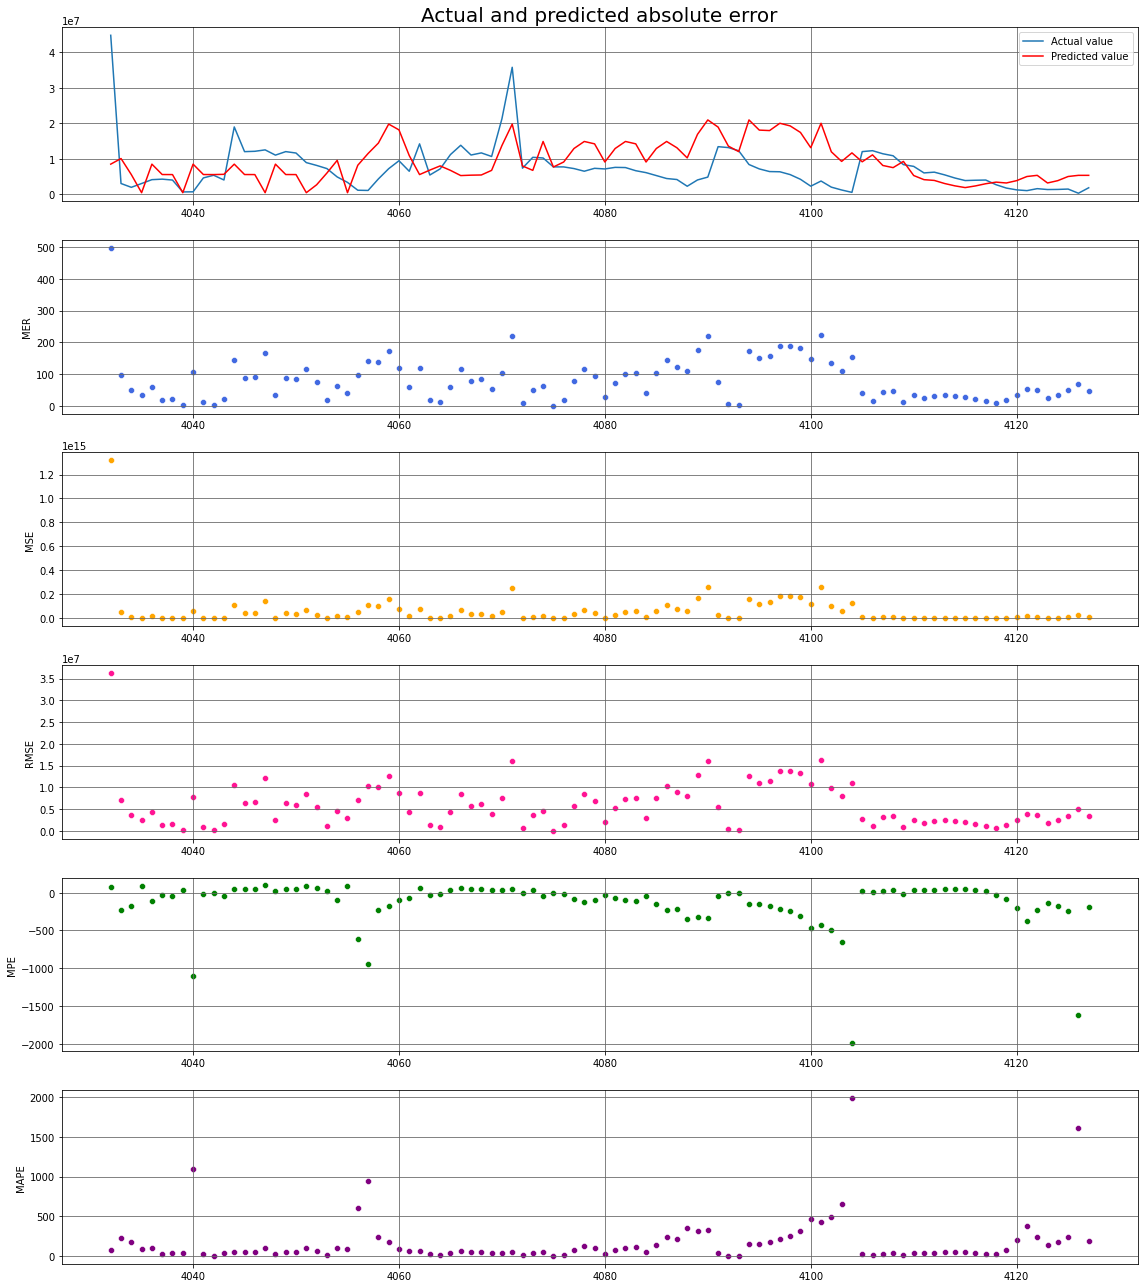

In [9]:
#Visualization
##Activate the next line if you want to show the day where the highest value of the MER observed
df3=df2[df2['Dates'].values==df2.nlargest(1,'MER').Dates.values]
##Activate the next line if you want to insert the date manually
##df3=df2[(df2['time'] >= '2019-05-25 00:00:00') & (df2['time'] <= '2019-05-25 23:45:00')]
from enum import auto
#df2=df2.set_index('time')
#merged=merged.reset_index()
for date, d in df3.groupby(df3['Dates']):
  fig, axes = plt.subplots(nrows=6, ncols=1,figsize=(16,18))
  ax1 = d['y_test'].plot(legend=True,linestyle = '-',label='Actual value',ax=axes[0])
  ax1 = d['y_preds'].plot(color='red',legend=True,style='-',label='Predicted value',ax=axes[0])
  ax1.legend(loc='upper right')
  ax1.set_title('Actual and predicted absolute error',  fontsize=20)
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  #ax2=sns.scatterplot(data=d,x = d.index,y=d['Absolute error'],ax=axes[2], color='crimson')
  ax2=sns.scatterplot(data=d,x = d.index,y=d['MPE'],ax=axes[4], color='green')
  ax3=sns.scatterplot(data=d,x = d.index,y=d['MAPE'],ax=axes[5], color='purple')
  ax4=sns.scatterplot(data=d,x = d.index,y=d['MSE'],ax=axes[2], color='orange')
  ax5=sns.scatterplot(data=d,x = d.index,y=d['RMSE'],ax=axes[3], color='deeppink')
  ax6=sns.scatterplot(data=d,x = d.index,y=d['MER'],ax=axes[1], color='royalblue')
  ax1.legend(loc='upper right')
  ax2.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax3.grid(b=True, which='major', color='#666666', linestyle='-')
  ax4.grid(b=True, which='major', color='#666666', linestyle='-')
  ax5.grid(b=True, which='major', color='#666666', linestyle='-')
  ax6.grid(b=True, which='major', color='#666666', linestyle='-')
  ax2.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax3.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax4.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax5.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax6.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  plt.tight_layout()
  plt.xlim=auto
  plt.ylim=auto
  ax1.xlim=auto
  ax2.ylim=auto


#15.11.2022 
##Determining the set points distribution

In [90]:

#d=df2
df2['Relative_error']=df2['y_preds'].div(df2.groupby('Dates')['y_preds'].transform('sum'))
df2['setpoint_per_15min']=df2['Relative_error']*96
#df2['new_interval_length']=15/df2['setpoint_per_15min']
#df2['new_interval_length_corrected']=df2['new_interval_length']*(1440/(df2.groupby('Dates')['new_interval_length'].transform('sum')))
##in der fall wenn wir kontrollieren wollen dass die Zahl an minuten passt (1440) dann : d=df2[:96] und dann ##d.new_interval_length_corrected.sum()
df2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,time,y_test,y_preds,Dates,Absolute error,MSE,RMSE,MPE,MAPE,MER,Relative_error,setpoint_per_15min
0,2019-01-04 00:00:00,27881001.5,14895306.4,2019-01-04,12985695.0,168628275829373.2,12985695.0,46.6,46.6,133.4,0.0,1.2
1,2019-01-04 00:15:00,24547584.6,9561989.1,2019-01-04,14985595.5,224568072791256.2,14985595.5,61.0,61.0,153.9,0.0,0.8
2,2019-01-04 00:30:00,5283988.1,18289606.9,2019-01-04,13005618.8,169146120438981.5,13005618.8,-246.1,246.1,133.6,0.0,1.5
3,2019-01-04 00:45:00,7443648.1,16709022.2,2019-01-04,9265374.1,85847157026128.0,9265374.1,-124.5,124.5,95.2,0.0,1.4
4,2019-01-04 01:00:00,6531875.6,10839130.2,2019-01-04,4307254.6,18552442525531.8,4307254.6,-65.9,65.9,44.2,0.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...
5947,2019-12-21 22:45:00,9548042.4,22677747.0,2019-12-21,13129704.6,172389143006143.5,13129704.6,-137.5,137.5,134.3,0.0,1.5
5948,2019-12-21 23:00:00,8231963.5,4767989.5,2019-12-21,3463974.1,11999116235539.7,3463974.1,42.1,42.1,35.4,0.0,0.3
5949,2019-12-21 23:15:00,12521802.6,12204452.7,2019-12-21,317349.8,100710925469.2,317349.8,2.5,2.5,3.2,0.0,0.8
5950,2019-12-21 23:30:00,9842391.5,10774385.0,2019-12-21,931993.6,868611983217.6,931993.6,-9.5,9.5,9.5,0.0,0.7




1.   'Setpoint_per_interval_cumulative': we determine if there are set points in an interval 
2.   'Set_points_Dist': we identify where in the interval is this set points.


In [87]:
#'Setpoint_per_interval_cumulative': we determine if there are set points in an interval
df2['Setpoint_per_interval_cumulative'] = (
    df2.loc[::-1] 
   .groupby(['Dates'])['setpoint_per_15min'].cumsum())
# calculating Slope of the line between two points and use it to solve the equation of the inversed function(Umkehrfunktion)
df2['Slope'] = (df2['Setpoint_per_interval_cumulative'].shift(-1)- df2['Setpoint_per_interval_cumulative'])/15
#get the value before the decimal point of the 'Setpoint_per_interval_cumulative'
df2['Asint']=df2['Setpoint_per_interval_cumulative'].astype(int)
#check if the value before the decimal point is changed in the next row
df2['check']=df2['Asint'].shift(-1)==df2['Asint']
#how much changed the value before the decimal point in the next row
######df2['range']=df2['Asint']-df2['Asint'].shift(-1)
df2['Set_point_Minus_cumulative']= df2['Asint']-df2['Setpoint_per_interval_cumulative']
#identify the column 'Start sarting by the value 0 to 96 steps with each 15 minute >>> 0,15,30,45,60,75.....etc.
initial_value = 0
constant_value = 15
desired_list_size = 96
result = np.arange(desired_list_size) * constant_value + initial_value
grouped = df2.groupby('Dates')
df_empty = pd.DataFrame(columns=df2.columns) 
df2=df_empty
for name, group in grouped:
  group['Start']= result
  #how much changed the value before the decimal point in the next row
  group['range']=group['Asint']-group['Asint'].shift(-1)
  df2 = df2.append(group)
df2['range'] = df2['range'].fillna(df2.Asint)
df2['slop_multi_start']=df2['Slope']*df2['Start']

#inverse function(Umkehrfunktion)
df2['Set_points_Dist']=(df2['slop_multi_start']+df2['Set_point_Minus_cumulative'])/df2['Slope']
df2[['Start','Asint','Set_points_Dist','range']]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,Start,Asint,Set_points_Dist,range
0,0.0,96,0.0,2.0
1,15.0,94,29.2,1.0
2,30.0,93,39.4,1.0
3,45.0,92,49.6,1.0
4,60.0,91,60.6,1.0
...,...,...,...,...
5947,1365.0,4,1372.7,1.0
5948,1380.0,3,1393.7,1.0
5949,1395.0,2,1413.4,0.0
5950,1410.0,2,1413.8,1.0


# worked one after the null value of the shift is filled for each date by 0



In [127]:
#'Setpoint_per_interval_cumulative': we determine if there are set points in an interval
df2['Setpoint_per_interval_cumulative'] = (
    df2.loc[::-1] 
   .groupby(['Dates'])['setpoint_per_15min'].cumsum())
# calculating Slope of the line between two points and use it to solve the equation of the inversed function(Umkehrfunktion)
df2['Slope'] = ((df2.groupby(['Dates'])['Setpoint_per_interval_cumulative'].shift(-1).fillna(0))- df2['Setpoint_per_interval_cumulative'])/15
#get the value before the decimal point of the 'Setpoint_per_interval_cumulative'
df2['Asint']=df2['Setpoint_per_interval_cumulative'].astype(int)
#check if the value before the decimal point is changed in the next row
df2['check']=df2['Asint'].shift(-1)==df2['Asint']
#how much changed the value before the decimal point in the next row
######df2['range']=df2['Asint']-df2['Asint'].shift(-1)
#################df2['Set_point_Minus_cumulative']= df2['Asint']-df2['Setpoint_per_interval_cumulative']
#identify the column 'Start sarting by the value 0 to 96 steps with each 15 minute >>> 0,15,30,45,60,75.....etc.
initial_value = 0
constant_value = 15
desired_list_size = 96
result = np.arange(desired_list_size) * constant_value + initial_value
grouped = df2.groupby('Dates')
df_empty = pd.DataFrame(columns=df2.columns) 
df2=df_empty
for name, group in grouped:
  group['Start']= result
  #how much changed the value before the decimal point in the next row
  group['range']=group['Asint']-group['Asint'].shift(-1)
  df2 = df2.append(group)
df2['range'] = df2['range'].fillna(df2.Asint)
df2['slop_multi_start']=df2['Slope']*df2['Start']

df321= df2[df2.range != 0]
df321=df321.loc[df321.index.repeat(df321.range)].reset_index(drop=True)
#determine the count in the group and then to determine the set point in the next step
df321['count'] = df321.groupby(df321.time).cumcount() 
#endresult is the set points
df321['endresult']=df321['Asint']-df321['count']

df321['Set_point_Minus_cumulative']= df321['endresult']-df321['Setpoint_per_interval_cumulative']
#inverse function(Umkehrfunktion)
df321['Set_points_Dist']=(df321['slop_multi_start']+df321['Set_point_Minus_cumulative'])/df321['Slope']
#df321[['Start','Asint','Set_points_Dist','range','endresult']]

df321[['time','Start','Slope','Setpoint_per_interval_cumulative','range','endresult','Set_points_Dist']]
#df2[['totesttheslop']]

,time,Start,Slope,Setpoint_per_interval_cumulative,range,endresult,Set_points_Dist
0,2019-01-04 00:00:00,0,-0.1,96.0,2.0,96,0.0
1,2019-01-04 00:00:00,0,-0.1,96.0,2.0,95,12.1
2,2019-01-04 00:15:00,15,-0.1,94.8,1.0,94,29.2
3,2019-01-04 00:30:00,30,-0.1,94.0,1.0,93,39.4
4,2019-01-04 00:45:00,45,-0.1,92.4,1.0,92,49.6
...,...,...,...,...,...,...,...
5941,2019-12-21 22:30:00,1350,-0.0,5.0,1.0,5,1350.5
5942,2019-12-21 22:45:00,1365,-0.1,4.8,1.0,4,1372.7
5943,2019-12-21 23:00:00,1380,-0.0,3.3,1.0,3,1393.7
5944,2019-12-21 23:30:00,1410,-0.0,2.2,1.0,2,1413.8


In [70]:
df321= df2[df2.range != 0]
df321=df321.loc[df321.index.repeat(df321.range)].reset_index(drop=True)
df321['Table'] = df321.groupby(df321.time).cumcount() 
df321['endresult']=df321['Asint']-df321['Table']
df321[['Asint','range','Table','endresult']]

,Asint,range,Table,endresult
0,96,2.0,0,96
1,96,2.0,1,95
2,94,1.0,0,94
3,93,1.0,0,93
4,92,1.0,0,92
...,...,...,...,...
5941,5,1.0,0,5
5942,4,1.0,0,4
5943,3,1.0,0,3
5944,2,1.0,0,2


In [59]:
df66=df321
#df66['Asint'] = df66.where(df66==df66.shift(),'')
##df66["Keep"] = 0
##df66.loc[df66.groupby('time')["Asint"].apply(lambda x: x-1).values, "Keep"] =df66.Asint-1
##df66[['Asint','Keep']]
##df66['KEEP111']=df66.groupby('time')["Asint"].apply(lambda x: np.where(x.duplicated(keep=False), 'dup', np.nan))
#df66['Dup'] = np.where(df['Asint'].duplicated(keep=False), 'dup', np.nan)
#df66['Dup'] = np.where(df66['Asint'].duplicated(keep=False), 'dup', np.nan)
#df66 = df66.loc[df66.index.repeat(df66.Asint)].assign(duration=1)
######df66['Group'] = df66.groupby(['time'])['Asint'].apply(lambda x: x if x.Asint.iloc[0] else x-1)
###df66

#####df66['Group'] = df66.groupby(['time'])["Asint"].transform(lambda x: x if x is x.shift(-1) else x-1)
grouped = df66.groupby(['time'])
df_empty_2 = pd.DataFrame(columns=df66.columns) 
dffrom_empty=df_empty_2
for name, group in grouped:
  group = group[group['Asint']].head(1)
  #group['num']=group['Asint'].apply(lambda x: x if x is group.iloc[0] else x-1)
  #group['num'] = np.where(df2['Asint'] == 0, 1, 0)
  #if group['Asint'].iloc[0]:
    #group['num'] =group['Asint'] 
  #elif ~(group['Asint'].iloc[0]):
   # group['num'] =group['Asint']-1
  dffrom_empty=dffrom_empty.append(group)
#dffrom_empty[['range','Asint','num']]

#dffrom_empty
#g = df66['Asint'].ne(df66['Asint'].shift()).cumsum().loc[~df66['first']]


KeyError: ignored

In [128]:


grouped = df321.groupby('Asint')
df_empty_2 = pd.DataFrame(columns=df321.columns) 
df222=df_empty_2
for name, group in grouped:
  #g = dfz['Asint'].ne(dfz['Asint'].shift()).cumsum()
  #dfz['Asint'] = dfz['Asint'] - dfz.groupby(g).cumcount()
  group['num']= group['Asint']-1

  df222 = df222.append(group)
    
  #group['Asint']= group['Asint'].sub(group['Asint'].shift())

  #how much changed the value before the decimal point in the next row
  #group['range']=group['Asint']-group['Asint'].shift(-1)
  #df2 = df2.append(group)
#group[['Asint','Asint111']]
df222

TypeError: ignored

NameError: ignored

In [30]:
#if ((df2['check']==True) & ((df2['range'].between(0,-1, inclusive=True)))):
 # df['new']=df2['Asint']-df2['Setpoint_per_interval_cumulative']
if df2['check']==True:
  print('hey')

ValueError: ignored

In [ ]:
def label_race (row):
   if row['eri_hispanic'] == 1 :
      return 'Hispanic'
   if row['eri_afr_amer'] + row['eri_asian'] + row['eri_hawaiian'] + row['eri_nat_amer'] + row['eri_white'] > 1 :
      return 'Two Or More'
   if row['eri_nat_amer'] == 1 :
      return 'A/I AK Native'
   if row['eri_asian'] == 1:
      return 'Asian'
   if row['eri_afr_amer']  == 1:
      return 'Black/AA'
   if row['eri_hawaiian'] == 1:
      return 'Haw/Pac Isl.'
   if row['eri_white'] == 1:
      return 'White'
   return 'Other'